## Run scsim simulator

Until the simulation overview, this code comes from the simulate_example_data.ipynb contained in the GitHub Repository:
https://github.com/dylkot/cNMF/tree/master/Extras

In [1]:
import numpy as np
from sklearn.decomposition import NMF
from scipy.stats.stats import pearsonr

In [2]:
! mkdir ./example_data

mkdir: ./example_data: File exists


In [3]:
# Simulation with 7 cell types and 3 cell types containing the 1 activity programme (deloc=1.5):
! python /Users/RachelJackson/scsim/run_scsim.py --outdir ./example_data --seed 14 --numsims 1 --K 7 --nproggoups 3 --ncells 2500 --doubletfrac 0.0 --deloc 1.5

Simulating cells
Simulating gene params
Simulating program
Simulating DE
Simulating cell-gene means
   - Getting mean for activity program carrying cells
   - Getting mean for non activity program carrying cells
   - Normalizing by cell libsize
Adjusting means
Simulating counts
0.380 minutes elapsed for seed 14


## Filter out cells or genes with too few counts

In [4]:
%matplotlib inline
import sys
sys.path.append('..')
from cnmf import load_df_from_npz, get_highvar_genes 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from bhtsne import tsne 
import palettable 
import matplotlib.gridspec as gridspec

In [5]:
counts = load_df_from_npz('./example_data/counts.npz')
counts.head()

,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene9991,Gene9992,Gene9993,Gene9994,Gene9995,Gene9996,Gene9997,Gene9998,Gene9999,Gene10000
Cell1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cell2,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,5
Cell3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Cell4,0,0,0,0,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
Cell5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
gene_thresh = (counts.shape[0]*.005) # only keep genes detected in 1/200 cells
keep_gene_ind = (counts>0).sum(axis=0)>gene_thresh
counts = counts.loc[:,keep_gene_ind]

In [7]:
np.shape(counts)

(2500, 7403)

Text(0.5, 0, 'log10 Counts Per Cell')

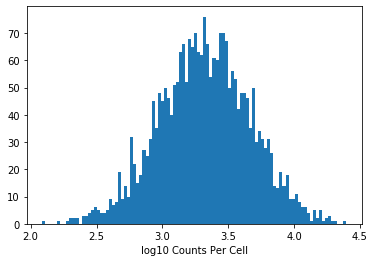

In [8]:
_ = plt.hist(counts.sum(axis=1).apply(np.log10), bins=100)
plt.xlabel('log10 Counts Per Cell')

In [9]:
counts.to_csv('./example_data/filtered_counts.txt', sep='\t')

In [10]:
cellparams = load_df_from_npz('./example_data/cellparams.npz')
cellparams.head()

,group,libsize,has_program,program_usage
Cell1,4,1913.24,False,0
Cell2,6,5003.53,False,0
Cell3,7,1231.24,False,0
Cell4,1,2780.57,False,0
Cell5,3,943.532,False,0


In [11]:
cellparams.to_csv('./example_data/groundtruth_cellparams.txt', sep='\t')

In [12]:
cellparams['group'].value_counts()

4    381
3    373
5    370
7    367
2    351
1    332
6    326
Name: group, dtype: int64

In [13]:
pd.crosstab(cellparams['group'], cellparams['has_program'])

has_program,False,True
group,,
1,204,128
2,231,120
3,247,126
4,381,0
5,370,0
6,326,0
7,367,0


In [14]:
geneparams = load_df_from_npz('./example_data/geneparams.npz')
geneparams.head()

,BaseGeneMean,is_outlier,outlier_ratio,gene_mean,prog_gene,prog_genemean,group1_DEratio,group1_genemean,group2_DEratio,group2_genemean,group3_DEratio,group3_genemean,group4_DEratio,group4_genemean,group5_DEratio,group5_genemean,group6_DEratio,group6_genemean,group7_DEratio,group7_genemean
Gene1,0.0323419,False,1,0.0323419,False,0.0323419,1,0.0323419,1,0.0323419,1,0.0323419,1,0.0323419,1,0.0323419,1,0.0323419,1,0.0323419
Gene2,0.162897,False,1,0.162897,False,0.162897,1,0.162897,1,0.162897,1,0.162897,1,0.162897,1,0.162897,1,0.162897,1,0.162897
Gene3,0.01904,False,1,0.01904,False,0.01904,1,0.01904,1,0.01904,1,0.01904,1,0.01904,1,0.01904,1,0.01904,1,0.01904
Gene4,0.0270809,False,1,0.0270809,False,0.0270809,1,0.0270809,1,0.0270809,1,0.0270809,1,0.0270809,1,0.0270809,1,0.0270809,1,0.0270809
Gene5,0.362571,False,1,0.362571,False,0.362571,1,0.362571,1,0.362571,1,0.362571,1,0.362571,1,0.362571,1,0.362571,1,0.362571


In [15]:
geneparams.to_csv('./example_data/groundtruth_geneparams.txt', sep='\t')

In [16]:
! ls ./example_data/

cellparams.npz             groundtruth_cellparams.txt
counts.npz                 groundtruth_geneparams.txt
filtered_counts.txt        tsne.txt
geneparams.npz


In [17]:
! rm ./example_data/geneparams.npz
! rm ./example_data/cellparams.npz

In [18]:
! ls ./example_data/

counts.npz                 groundtruth_geneparams.txt
filtered_counts.txt        tsne.txt
groundtruth_cellparams.txt


In [19]:
TPM = counts.div(counts.sum(axis=1), axis=0) * (10**6)  #normalisation using library counts

(gene_counts_stats, gene_fano_parameters) = get_highvar_genes(TPM.values, numgenes=2000) #increased from 2000


TPM_hvgs = TPM.iloc[:,gene_counts_stats.high_var.values]

## And run PCA
PCs = PCA(n_components=10).fit_transform(preprocessing.scale(TPM_hvgs))
PCs = pd.DataFrame(PCs, index=TPM_hvgs.index, columns=['PC%d' % i for i in range(1,11)])
PCs.head()

## And run tSNE
tsne_results = pd.DataFrame(tsne(PCs.values), index=PCs.index, columns=['TSNE1', 'TSNE2'])
tsne_results.to_csv('./example_data/tsne.txt', sep='\t')

In [20]:
tsnedat = pd.merge(left=tsne_results, right=cellparams, left_index=True, right_index=True)

tsnedat['extra-status'] = 'Normal'
tsnedat.loc[tsnedat['has_program'], 'extra-status'] = 'program'

In [21]:
cell_tableau10_color_id = tsnedat['group'].astype(int).values - 1
cell_tableau10_color = np.array(palettable.tableau.Tableau_10.colors[:-1])[cell_tableau10_color_id]/255.

activity_color = np.zeros((tsnedat.shape[0], 4))
activity_color[:, 3] = tsnedat['has_program'].astype(float)
doublet_color = np.array(palettable.tableau.TableauMedium_10.colors[5])/255. 

In [22]:
normal_filter = tsnedat['extra-status'] == 'Normal'
doublet_filter = tsnedat['extra-status'] == 'doublet'
activity_filter = tsnedat['extra-status'] == 'program'
activity_and_doublet_filter = tsnedat['extra-status'] == 'program & doublet'

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(0, 1)

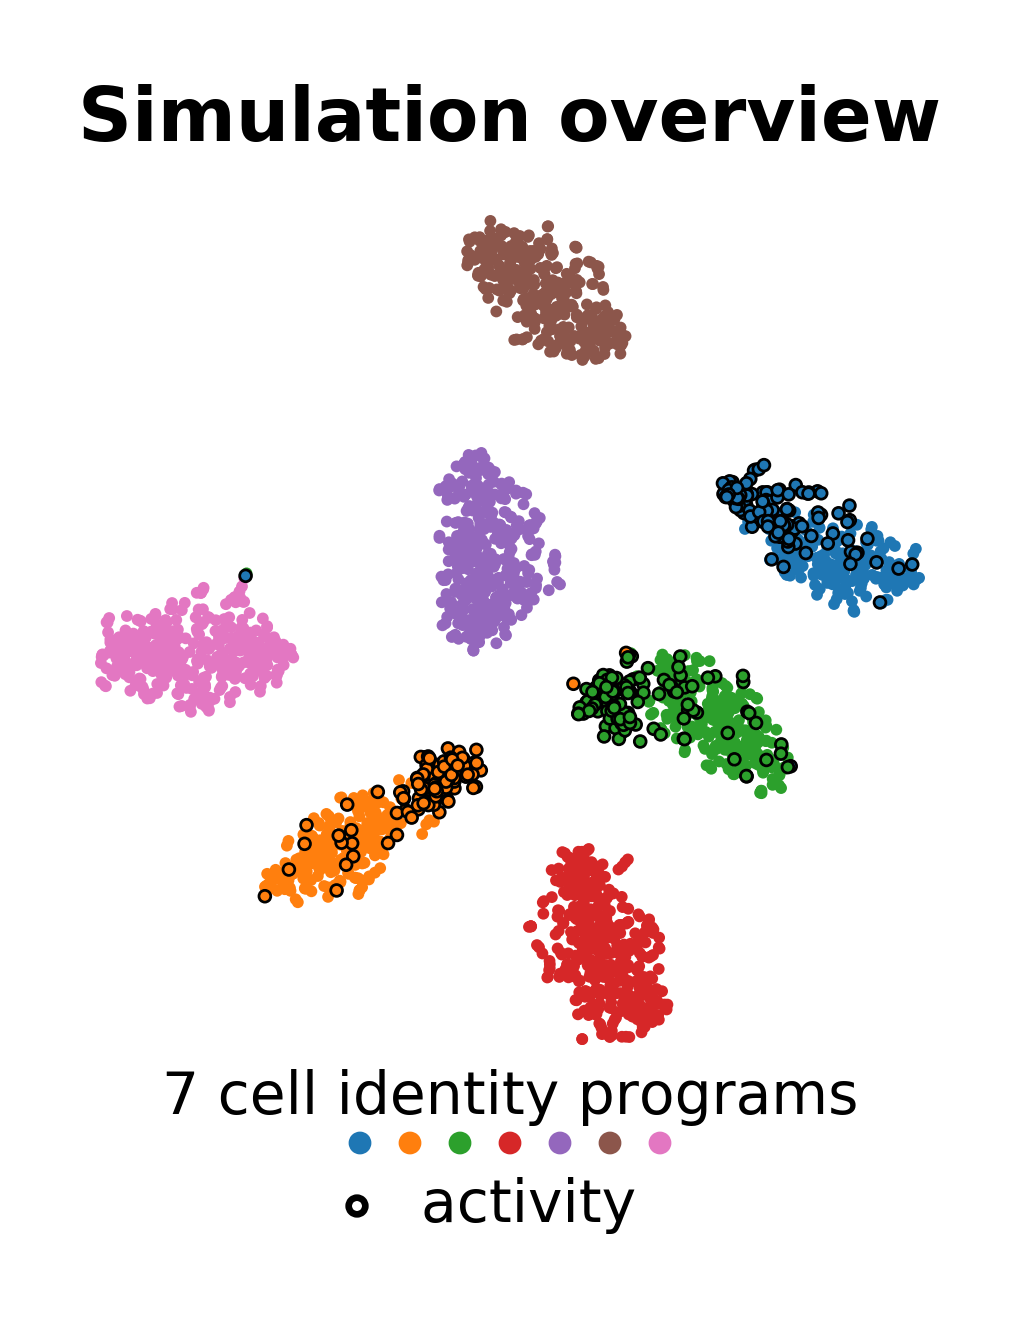

In [54]:
K = 7
fig = plt.figure(figsize=(1.5, 2), dpi=600)
gs = gridspec.GridSpec(3, 1, fig, 0,0,1,1,
                       hspace=0, wspace=0,
                       height_ratios=[0.2, 1.5, 0.3],
                       width_ratios=[1])

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, xticks=[], yticks=[])

x = tsnedat['TSNE1']
y = tsnedat['TSNE2']


curr_filter = normal_filter


ax.scatter(x[curr_filter], y[curr_filter],
          facecolor=cell_tableau10_color[curr_filter.values],
           edgecolor='none',
           rasterized=True, s=2)

curr_filter = activity_filter
ax.scatter(x[curr_filter], y[curr_filter],
          facecolor=cell_tableau10_color[curr_filter.values],
          edgecolor=activity_color[curr_filter.values], linewidth=0.33,
           rasterized=False, s=2)


curr_filter = doublet_filter | activity_and_doublet_filter
ax.scatter(x[curr_filter], y[curr_filter],
          c=doublet_color,
          edgecolor='none', marker='x', linewidth=0.4,
          s=1)

curr_filter = activity_and_doublet_filter
ax.scatter(x[curr_filter], y[curr_filter],
          facecolor='none',
          edgecolor=activity_color[curr_filter.values], linewidth=0.33,
           rasterized=False, s=2)


ax = fig.add_subplot(gs[0, 0],
          frameon=False, xticks=[], yticks=[], xlim=[0,1], ylim=[0,1])

ax.text(0.50, 0.5, 'Simulation overview', va='center', ha='center', fontsize=9, fontdict=dict(weight='bold'),
        clip_on=False)


ax = fig.add_subplot(gs[2, 0],
          frameon=False, xticks=[], yticks=[], xlim=[0,1], ylim=[0,1])

ax.text(0.50, 0.9, '%d cell identity programs' % K, va='center', ha='center', fontsize=7,
        clip_on=False)

leg_x = np.arange(K)/18
leg_x -= leg_x.mean()
leg_x += 0.5

ax.scatter(leg_x, np.ones(K)*0.65, c=np.array(palettable.tableau.Tableau_10.colors[:K])/255, s=3)



activity_y = 0.30
ax.text(0.5, activity_y, '  activity', verticalalignment='center', ha='center', fontsize=7,
        clip_on=False)

ax.scatter([0.33], [activity_y], 
           facecolor='none', edgecolor='k', linewidth=0.8, s=4)

ax.set_xlim([0,1])
ax.set_ylim([0,1])

In [24]:
! mv example_data simulated_example_data 

mv: rename example_data to simulated_example_data/example_data: Directory not empty


In [25]:
! tar -czvf example_data_20191024.tar.gz ./simulated_example_data/*

a ./simulated_example_data/counts.npz
a ./simulated_example_data/example_data
a ./simulated_example_data/example_data/filtered_counts.txt
a ./simulated_example_data/example_data/counts.npz
a ./simulated_example_data/example_data/groundtruth_cellparams.txt
a ./simulated_example_data/example_data/groundtruth_geneparams.txt
a ./simulated_example_data/example_data/tsne.txt
a ./simulated_example_data/filtered_counts.txt
a ./simulated_example_data/groundtruth_cellparams.txt
a ./simulated_example_data/groundtruth_geneparams.txt
a ./simulated_example_data/tsne.txt


NMF for n_components=9:

In [26]:
model = NMF(n_components=9, init='random', random_state=0, beta_loss='kullback-leibler', solver='mu')
W = model.fit_transform(TPM_hvgs)
H = model.components_

t-SNE plot coloured by factor weight:

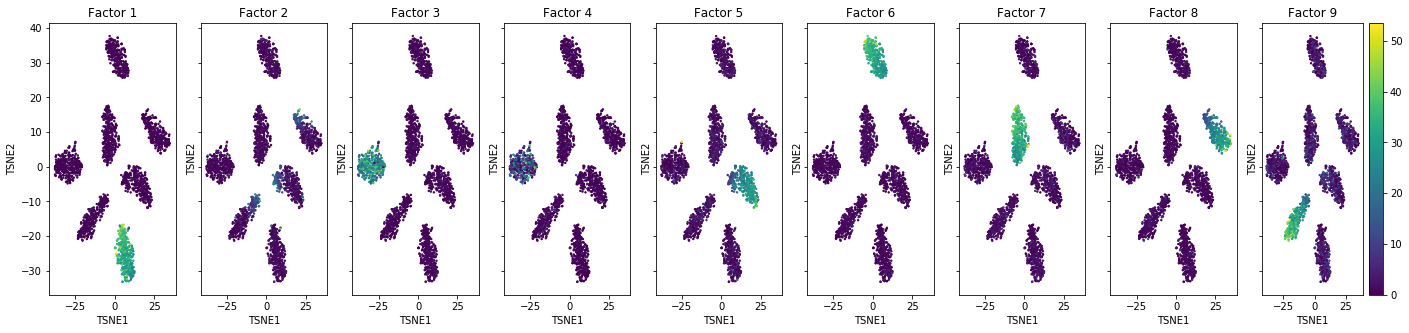

In [53]:
fig, axs = plt.subplots(1,9,figsize=(24,5), sharey=True)
K = 2
x = tsnedat['TSNE1']
y = tsnedat['TSNE2']


curr_filter = normal_filter
for i in range(9):
    sc=axs[i].scatter(x,  y, c=W[:,i], s=2)
    axs[i].set_xlabel('TSNE1')
    axs[i].set_ylabel('TSNE2')
    axs[i].set_title("Factor "+str(i+1))
plt.colorbar(sc)
plt.show()

Histogram of cell factor weights by cell type:

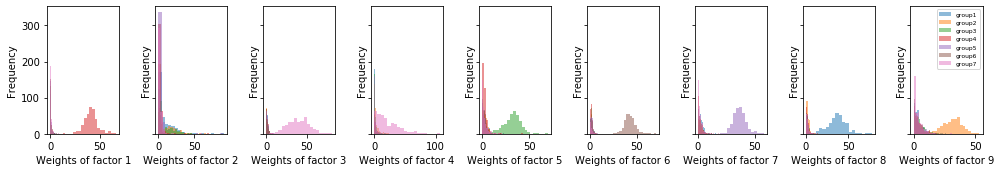

In [28]:
fig, axs = plt.subplots(1,9,figsize=(14,2.5), sharey=True)
cells_group1_idx = list(np.where(cellparams['group'].values == 1)[0])
cells_group2_idx = list(np.where(cellparams['group'].values == 2)[0])
cells_group3_idx = list(np.where(cellparams['group'].values == 3)[0])
cells_group4_idx = list(np.where(cellparams['group'].values == 4)[0])
cells_group5_idx = list(np.where(cellparams['group'].values == 5)[0])
cells_group6_idx = list(np.where(cellparams['group'].values == 6)[0])
cells_group7_idx = list(np.where(cellparams['group'].values == 7)[0])
for k in range(9):
    axs[k].hist(W[cells_group1_idx,k],20,alpha=0.5,label='group1')
    axs[k].hist(W[cells_group2_idx,k],20,alpha=0.5,label='group2')
    axs[k].hist(W[cells_group3_idx,k],20,alpha=0.5,label='group3')
    axs[k].hist(W[cells_group4_idx,k],20,alpha=0.5,label='group4')
    axs[k].hist(W[cells_group5_idx,k],20,alpha=0.5,label='group5')
    axs[k].hist(W[cells_group6_idx,k],20,alpha=0.5,label='group6')
    axs[k].hist(W[cells_group7_idx,k],20,alpha=0.5,label='group7')
    axs[k].set_xlabel('Weights of factor '+str(k+1))
    axs[k].set_ylabel('Frequency')
plt.legend(fontsize=6)
plt.tight_layout()
plt.show()

Histogram of cell factor weights by activity program usage:

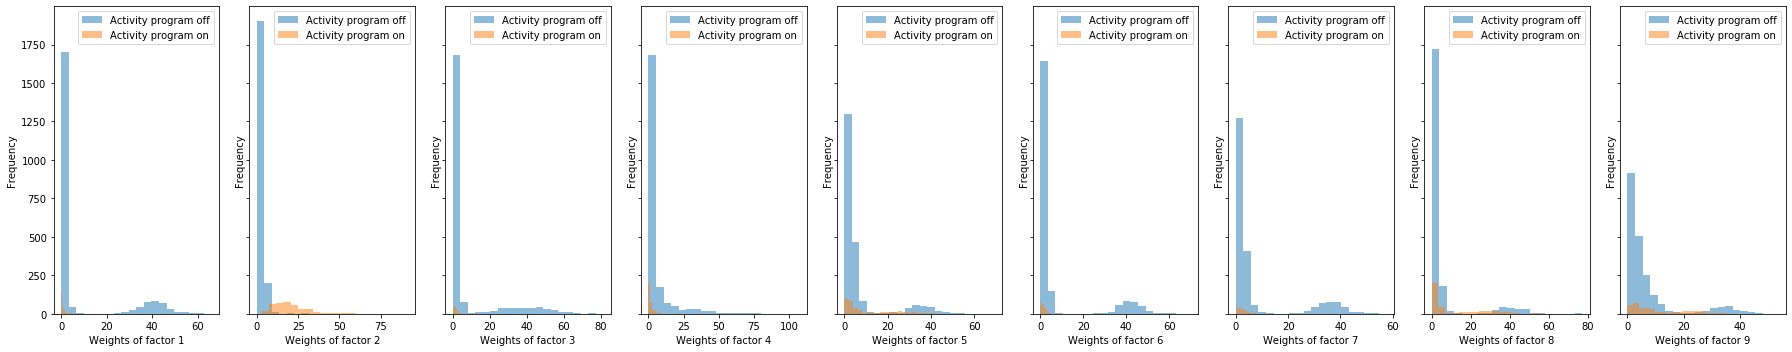

In [29]:
fig, axs = plt.subplots(1,9,figsize=(25,5), sharey=True)
programs_idxon = list(np.where(cellparams['program_usage'].values != 0)[0])
programs_idxoff = list(np.where(cellparams['program_usage'].values == 0)[0])
for k in range(9):
    axs[k].hist(W[programs_idxoff,k],20,alpha=0.5,label='Activity program off')
    axs[k].hist(W[programs_idxon,k],20,alpha=0.5,label='Activity program on')
    axs[k].legend(fontsize=10)
    axs[k].set_xlabel('Weights of factor '+str(k+1))
    axs[k].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

Heatmap of cell vs factors, weighted by cell weights:

[   0  332  683 1056 1437 1807 2133 2500]
['Cell Type-1', 'Cell Type-2', 'Cell Type-3', 'Cell Type-4', 'Cell Type-5', 'Cell Type-6', 'Cell Type-7'] [166, 508, 870, 1247, 1622, 1970, 2317]


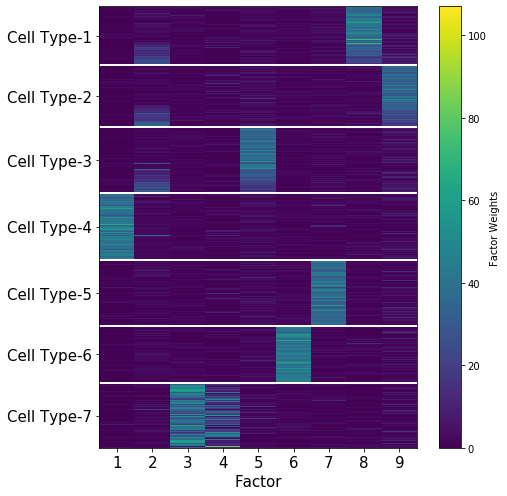

In [30]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator, FixedLocator)
cellparams['tmp_idx'] = range(cellparams.shape[0])
rearranged_rows = cellparams.sort_values(by=['group', 'program_usage'])['tmp_idx'].values
## set up ticks for plots
wgt_labels = [str(i+1) for i in range(9)] # list of weight labels
wgt_tick_positions = range(9)
# set up ticks for separating known cell groups
switch_idx = [(cellparams['group'] == i).sum() for i in range(len(set(cellparams['group'] ))) ]
switch_idx = list(np.cumsum(switch_idx))  
switch_idx = np.append(switch_idx, len(cellparams['group']))
print(switch_idx)
# set up ticks for labelling cell types
cell_group_ticks = [switch_idx[i-1] + int(np.ceil(0.5*(switch_idx[i]-switch_idx[i-1]))) for i in range(1,len(switch_idx))]
cell_group_labels = ['Cell Type-'+str(i+1) for i in range(len(set(cellparams['group'])))]
print(cell_group_labels,cell_group_ticks)

plt.figure(figsize=(7,7))
## plot heatmap ##
plt.imshow(W[rearranged_rows,:],aspect=.005,interpolation='nearest')#,aspect=.001)
plt.colorbar(label="Factor Weights")
ax = plt.gca()
## set ticks and labels for weights ##
ax.set_xticks(wgt_tick_positions)
ax.set_xticklabels(wgt_labels,fontsize=15)
ax.set_xlabel("Factor", fontsize=15)
## set (major) ticks and labels for cell groups ##
ax.yaxis.set_major_locator(FixedLocator(cell_group_ticks))
ax.set_yticklabels(cell_group_labels,minor=False,fontsize=15,ha='right')
## set (minor) ticks and plot separators (can remove this part if needed) ##
ax.yaxis.set_minor_locator(FixedLocator(switch_idx))
ax.tick_params(which='minor', length=0)
plt.grid(True, which='minor', linewidth=2,color='White')
plt.tight_layout()
plt.show()

Correlation plot of NMF gene factor weights vs genes expressed in each identity programme (this is only known as we are simulating the data):

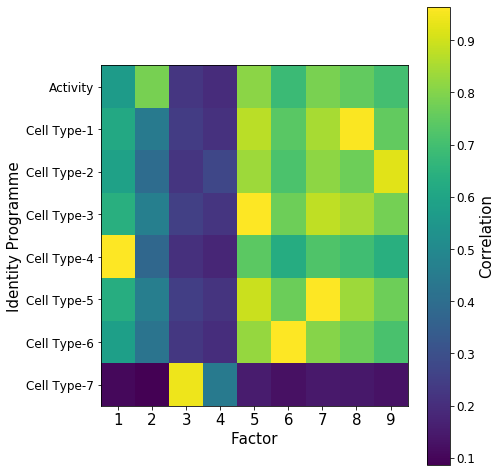

In [37]:
factors=9
x=factors
metadata=8
correlation=np.zeros((metadata,factors))
for j in range(factors):
    correlation[0,j]=pearsonr(H[j,:],geneparams['prog_genemean'][TPM.columns[np.where(gene_counts_stats.high_var.values)[0]]])[0]
    correlation[1,j]=pearsonr(H[j,:],geneparams['group1_genemean'][TPM.columns[np.where(gene_counts_stats.high_var.values)[0]]])[0]
    correlation[2,j]=pearsonr(H[j,:],geneparams['group2_genemean'][TPM.columns[np.where(gene_counts_stats.high_var.values)[0]]])[0]
    correlation[3,j]=pearsonr(H[j,:],geneparams['group3_genemean'][TPM.columns[np.where(gene_counts_stats.high_var.values)[0]]])[0]
    correlation[4,j]=pearsonr(H[j,:],geneparams['group4_genemean'][TPM.columns[np.where(gene_counts_stats.high_var.values)[0]]])[0]
    correlation[5,j]=pearsonr(H[j,:],geneparams['group5_genemean'][TPM.columns[np.where(gene_counts_stats.high_var.values)[0]]])[0]
    correlation[6,j]=pearsonr(H[j,:],geneparams['group6_genemean'][TPM.columns[np.where(gene_counts_stats.high_var.values)[0]]])[0]
    correlation[7,j]=pearsonr(H[j,:],geneparams['group7_genemean'][TPM.columns[np.where(gene_counts_stats.high_var.values)[0]]])[0]


from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator, FixedLocator)
from matplotlib.pylab import *
## set up ticks for plots
wgt_labels = [str(i+1) for i in range(x)] # list of weight labels
wgt_tick_positions = range(x)
plt.figure(figsize=(7,7))
## plot heatmap ##
plt.imshow(correlation,interpolation='nearest',aspect=1.25)#,aspect=.001)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=12)
cb.ax.set_ylabel('Correlation',fontsize=15)
ax = plt.gca()
## set ticks and labels for weights ##
ax.set_xticks(wgt_tick_positions)
ax.set_xticklabels(wgt_labels,fontsize=15)
ax.set_xlabel("Factor", fontsize=15)
labels=['Activity','Cell Type-1', 'Cell Type-2', 'Cell Type-3', 'Cell Type-4', 'Cell Type-5', 'Cell Type-6', 'Cell Type-7']
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels,fontsize=12,ha='right')
ax.set_ylabel("Identity Programme",fontsize=15)
plt.grid(True, which='minor', linewidth=2,color='White')
plt.tight_layout()
plt.show()

Run cross-validation with a Kullback-Leibler divergence cost function:

In [38]:
sqrt_TPM_hvgs=np.sqrt(TPM_hvgs)

In [43]:
from scipy import special
p=-1
seeds=[10,123,1001,101010,234567]
training_costs=np.zeros((30,10,5))
test_costs=np.zeros((30,10,5))
for i in seeds:
    np.random.seed(i)
    p+=1
    nrows = 2500
    ncols = 2000
    pmask = 0.3 # mask 30% of entries
    M=np.random.choice([0, 1], size=(nrows,ncols), p=[pmask, 1-pmask])
    Z_init=np.multiply(M,sqrt_TPM_hvgs)
    ntest=[]
    ntrain=[]
    for n in range(10):
        Z=Z_init #Z_init is the same for all n_components
        for l in range(30):
            print(l)
            model= NMF(n_components=n+1, init='random', random_state=0, beta_loss='kullback-leibler', solver='mu')
            U = model.fit_transform(Z)
            V = model.components_
            UV=np.matmul(U,V)
            Z=Z_init+np.multiply((1-M),UV)
            training_cost=((special.kl_div(Z,UV+1e-10)).sum(axis=0)).sum(axis=0) #KLD
            training_costs[l,n,p]=training_cost
            test_cost=((special.kl_div(np.multiply((1-M),sqrt_TPM_hvgs), np.multiply((1-M),UV)+1e-10)).sum(axis=0)).sum(axis=0)
            test_costs[l,n,p]=test_cost
    ntest.append((1-M).sum())
    ntrain.append((M).sum()) 
    print(ntest)
    print(ntrain)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[1501158]
[3498842]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9


Plot cross-validation results:

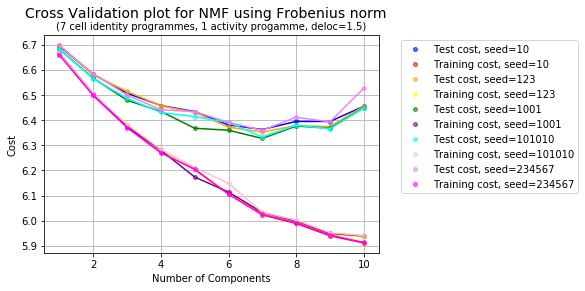

In [50]:
j=list(range(1,11))
plt.plot(j, test_costs[29,:,0]/1501158, "o",markersize=4, alpha=0.6, color='blue', label="Test cost, seed=10")
plt.plot(j, test_costs[29,:,0]/1501158, color="blue")
plt.plot(j, training_costs[29,:,0]/3498842, "o",markersize=4, alpha=0.6, color="red", label="Training cost, seed=10")
plt.plot(j, training_costs[29,:,0]/3498842, color="red")
plt.plot(j, test_costs[29,:,1]/1499313, "o",markersize=4, alpha=0.6, color='orange', label="Test cost, seed=123")
plt.plot(j, test_costs[29,:,1]/1499313, color="orange")
plt.plot(j, training_costs[29,:,1]/3500687, "o",markersize=4, alpha=0.6, color="yellow", label="Training cost, seed=123")
plt.plot(j, training_costs[29,:,1]/3500687, color="yellow")
plt.plot(j, test_costs[29,:,2]/1501601, "o",markersize=4, alpha=0.6, color='green', label="Test cost, seed=1001")
plt.plot(j, test_costs[29,:,2]/1501601, color="green")
plt.plot(j, training_costs[29,:,2]/3498399, "o",markersize=4, alpha=0.6, color="purple", label="Training cost, seed=1001")
plt.plot(j, training_costs[29,:,2]/3498399, color="purple")
plt.plot(j, test_costs[29,:,3]/1500311, "o",markersize=4, alpha=0.6, color='cyan', label="Test cost, seed=101010")
plt.plot(j, test_costs[29,:,3]/1500311, color="cyan")
plt.plot(j, training_costs[29,:,3]/3499689, "o",markersize=4, alpha=0.6, color="pink", label="Training cost, seed=101010")
plt.plot(j, training_costs[29,:,3]/3499689, color="pink")
plt.plot(j, test_costs[29,:,4]/1501375, "o",markersize=4, alpha=0.6, color='violet', label="Test cost, seed=234567")
plt.plot(j, test_costs[29,:,4]/1501375, color="violet")
plt.plot(j, training_costs[29,:,4]/3498625, "o",markersize=4, alpha=0.6, color="magenta", label="Training cost, seed=234567")
plt.plot(j, training_costs[29,:,4]/3498625, color="magenta")
plt.suptitle("Cross Validation plot for NMF using Frobenius norm", fontsize=14)
plt.title("(7 cell identity programmes, 1 activity progamme, deloc=1.5)", fontsize=10)
plt.xlabel("Number of Components")
plt.ylabel("Cost")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Run cross-validation with a Frobenius norm cost function:

In [45]:
p=-1
seeds=[10,123,1001,101010,234567]
training_costs1=np.zeros((30,10,5))
test_costs1=np.zeros((30,10,5))
for i in seeds:
    np.random.seed(i)
    p+=1
    nrows = 2500
    ncols = 2000
    pmask = 0.3 # mask 30% of entries
    M=np.random.choice([0, 1], size=(nrows,ncols), p=[pmask, 1-pmask])
    Z_init=np.multiply(M,sqrt_TPM_hvgs)
    ntest1=[]
    ntrain1=[]
    for n in range(10):
        Z=Z_init #Z_init is the same for all n_components
        for l in range(30):
            print(l)
            model= NMF(n_components=n+1, init='random', random_state=0, solver='mu')
            U = model.fit_transform(Z)
            V = model.components_
            UV=np.matmul(U,V)
            Z=Z_init+np.multiply((1-M),UV)
            training_cost=(np.linalg.norm(UV-Z))**2
            training_costs1[l,n,p]=training_cost#Froebenius norm
            test_cost=(np.linalg.norm(np.multiply((1-M),UV-sqrt_TPM_hvgs)))**2
            test_costs1[l,n,p]=test_cost
    ntest1.append((1-M).sum())
    ntrain1.append((M).sum()) 
    print(ntest1)
    print(ntrain1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


4
5
6
7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[1501158]
[3498842]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[1499313]
[3500687]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[1501601]
[3498399]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[1500311]
[3499689]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


1
2
3
4
5
6
7
8
9
10
11
12


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0
1
2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
[1501375]
[3498625]


Plot cross-validation results: 

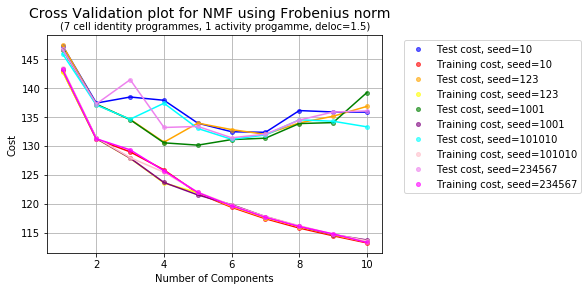

In [49]:
j=list(range(1,11))
plt.plot(j, test_costs1[29,:,0]/1501158, "o",markersize=4, alpha=0.6, color='blue', label="Test cost, seed=10")
plt.plot(j, test_costs1[29,:,0]/1501158, color="blue")
plt.plot(j, training_costs1[29,:,0]/3498842, "o",markersize=4, alpha=0.6, color="red", label="Training cost, seed=10")
plt.plot(j, training_costs1[29,:,0]/3498842, color="red")
plt.plot(j, test_costs1[29,:,1]/1499313, "o",markersize=4, alpha=0.6, color='orange', label="Test cost, seed=123")
plt.plot(j, test_costs1[29,:,1]/1499313, color="orange")
plt.plot(j, training_costs1[29,:,1]/3500687, "o",markersize=4, alpha=0.6, color="yellow", label="Training cost, seed=123")
plt.plot(j, training_costs1[29,:,1]/3500687, color="yellow")
plt.plot(j, test_costs1[29,:,2]/1501601, "o",markersize=4, alpha=0.6, color='green', label="Test cost, seed=1001")
plt.plot(j, test_costs1[29,:,2]/1501601, color="green")
plt.plot(j, training_costs1[29,:,2]/3498399, "o",markersize=4, alpha=0.6, color="purple", label="Training cost, seed=1001")
plt.plot(j, training_costs1[29,:,2]/3498399, color="purple")
plt.plot(j, test_costs1[29,:,3]/1500311, "o",markersize=4, alpha=0.6, color='cyan', label="Test cost, seed=101010")
plt.plot(j, test_costs1[29,:,3]/1500311, color="cyan")
plt.plot(j, training_costs1[29,:,3]/3499689, "o",markersize=4, alpha=0.6, color="pink", label="Training cost, seed=101010")
plt.plot(j, training_costs1[29,:,3]/3499689, color="pink")
plt.plot(j, test_costs1[29,:,4]/1501375, "o",markersize=4, alpha=0.6, color='violet', label="Test cost, seed=234567")
plt.plot(j, test_costs1[29,:,4]/1501375, color="violet")
plt.plot(j, training_costs1[29,:,4]/3498625, "o",markersize=4, alpha=0.6, color="magenta", label="Training cost, seed=234567")
plt.plot(j, training_costs1[29,:,4]/3498625, color="magenta")
plt.xlabel("Number of Components")
plt.ylabel("Cost")
plt.suptitle("Cross Validation plot for NMF using Frobenius norm", fontsize=14)
plt.title("(7 cell identity programmes, 1 activity progamme, deloc=1.5)", fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()